In [96]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import math
import geopandas as gpd
import csv

#import geoplot as gplt


from datetime import datetime
from pylab import *
from shapely.ops import nearest_points

In [97]:
df = pd.read_csv('clean_nyc_airbnb.csv')
df2 = pd.read_csv('clean_nyc_sale.csv')

In [98]:
#CALCULATE ANNUAL EARNING FROM AIRBNB
#assume the given occupnacy percentage
#assume: airbnb take 15%, maintainence 15% -> profit only 70%
df['annual_earn'] = df['price'] * 0.75 * df['occupancy_%']/100 * 365

In [105]:
df

,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,...,calculated_host_listings_count,availability_365,activity,occupancy_%,how_far_km,annual_earn,annual_mortgage,annual_cost,ROI_mortgage,ROI
0,2595,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,...,2,355,Active,3.0,7.330251,1847.8125,46461.177271,29966.666667,-96.022889,-93.833774
1,3831,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-05-07,...,1,194,Active,47.0,9.695046,11450.9625,15465.525360,9975.000000,-25.958141,14.796617
2,5099,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,...,1,129,Active,65.0,7.263750,35587.5000,46461.177271,29966.666667,-23.403792,18.756952
3,5178,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,...,1,220,Active,40.0,7.695761,8650.5000,46461.177271,29966.666667,-81.381229,-71.132925
4,5238,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-09-06,...,4,188,Active,48.0,7.823571,19710.0000,46461.177271,29966.666667,-57.577485,-34.226919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25983,36425863,Manhattan,Upper East Side,40.78099,-73.95366,Private room,129,1,1,2019-07-07,...,1,147,Active,60.0,8.613975,21188.2500,46461.177271,29966.666667,-54.395796,-29.293938
25984,36427429,Queens,Flushing,40.75104,-73.81459,Private room,45,1,1,2019-07-07,...,6,339,Active,7.0,15.835060,862.3125,24775.254817,15979.616667,-96.519461,-94.603672
25985,36438336,Staten Island,Great Kills,40.54179,-74.14275,Private room,235,1,1,2019-07-07,...,1,87,Active,76.0,26.005483,48891.7500,21447.595737,13833.333333,127.959118,253.434337
25986,36442252,Bronx,Mott Haven,40.80787,-73.92400,Entire home/apt,100,1,2,2019-07-07,...,1,40,Active,89.0,11.133406,24363.7500,18346.738522,11833.333333,32.796082,105.890845


In [99]:
#DETERMINE MEDIAN PRICE OF PROPERTY IN EACH NEIGHBOURHOOD GROUP

#split into neighbourhood_group

br_sale = df2.loc[df2["neighbourhood_group"] == 'Bronx']
bk_sale = df2.loc[df2["neighbourhood_group"] == 'Brooklyn']
mn_sale = df2.loc[df2["neighbourhood_group"] == 'Manhattan']
qn_sale = df2.loc[df2["neighbourhood_group"] == 'Queens']
si_sale = df2.loc[df2["neighbourhood_group"] == 'Staten Island']

br_med_cost = br_sale['sale_price'].median()
bk_med_cost = bk_sale['sale_price'].median()
mn_med_cost = mn_sale['sale_price'].median()
qn_med_cost = qn_sale['sale_price'].median()
si_med_cost = si_sale['sale_price'].median()

In [100]:
#DEFINE COST OR MORTGAGE RATE
#THIS WILL BE DETERMINED BASED ON SALE_PRICE
#i.e. total sale price will determine total mortgage

#Assuming fixed annual interest rate

def mortgage_calculator(p, i, n):
    
    '''
    The function calculate the periodic payment
    input: initial payment p, fixed annual interest rate i, total number of payment n
    output: perdioc payment amount
    Example:
        initial payment: p = 500,000
        fixed annual interest rate: i = 2.75
        30-year-loan with yearly payment: n = 30
    '''
    
    if i > 0: 
        A = p * i / ( 1 - ( 1 + i ) ** (-n) )
    elif i == 0:
        A = p / n
    else:
        print("print please input positive anual interest rate i")
    return A   

#assume current fixed annual interest rate for 30year loan
#assume median price per neighbourhood as initial cost
n = 30
i = 0.031
no_i = 0.0

#add a mortgage column
# create a list of our conditions
conditions = [
    (df['neighbourhood_group'] == 'Brooklyn'),
    (df['neighbourhood_group'] == 'Bronx'),
    (df['neighbourhood_group'] == 'Manhattan'),
    (df['neighbourhood_group'] == 'Queens'),
    (df['neighbourhood_group'] == 'Staten Island')
    ]

# create a list of the values we want to assign for each condition
values = [mortgage_calculator(bk_med_cost, i, n),
         mortgage_calculator(br_med_cost, i, n),
         mortgage_calculator(mn_med_cost, i, n),
         mortgage_calculator(qn_med_cost, i, n),
         mortgage_calculator(si_med_cost, i, n)]

no_i_values = [mortgage_calculator(bk_med_cost, no_i, n),
         mortgage_calculator(br_med_cost, no_i, n),
         mortgage_calculator(mn_med_cost, no_i, n),
         mortgage_calculator(qn_med_cost, no_i, n),
         mortgage_calculator(si_med_cost, no_i, n)]

# create a new column and use np.select to assign values to it using our lists as arguments
df['annual_mortgage'] = np.select(conditions, values) #with bank interest
df['annual_cost'] = np.select(conditions, no_i_values) #without bank interest

In [94]:
#performance = whether or revenue is positive or negative
df.loc[(df['annual_earn'] - df['annual_cost']) > 0, 'performance'] = 1
df.loc[(df['annual_earn'] - df['annual_cost']) < 0, 'performance'] = 0

,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,...,calculated_host_listings_count,availability_365,activity,occupancy_%,how_far_km,annual_earn,annual_mortgage,annual_cost,performance,revenue
0,2595,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,...,2,355,Active,3.0,7.330251,1847.8125,46461.177271,29966.666667,0.0,negative
1,3831,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-05-07,...,1,194,Active,47.0,9.695046,11450.9625,15465.525360,9975.000000,1.0,positive
2,5099,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,...,1,129,Active,65.0,7.263750,35587.5000,46461.177271,29966.666667,1.0,positive
3,5178,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,...,1,220,Active,40.0,7.695761,8650.5000,46461.177271,29966.666667,0.0,negative
4,5238,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-09-06,...,4,188,Active,48.0,7.823571,19710.0000,46461.177271,29966.666667,0.0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25983,36425863,Manhattan,Upper East Side,40.78099,-73.95366,Private room,129,1,1,2019-07-07,...,1,147,Active,60.0,8.613975,21188.2500,46461.177271,29966.666667,0.0,negative
25984,36427429,Queens,Flushing,40.75104,-73.81459,Private room,45,1,1,2019-07-07,...,6,339,Active,7.0,15.835060,862.3125,24775.254817,15979.616667,0.0,negative
25985,36438336,Staten Island,Great Kills,40.54179,-74.14275,Private room,235,1,1,2019-07-07,...,1,87,Active,76.0,26.005483,48891.7500,21447.595737,13833.333333,1.0,positive
25986,36442252,Bronx,Mott Haven,40.80787,-73.92400,Entire home/apt,100,1,2,2019-07-07,...,1,40,Active,89.0,11.133406,24363.7500,18346.738522,11833.333333,1.0,positive


In [104]:
#calculate ROI

df.loc[:, 'ROI_mortgage'] = ( df['annual_earn'] - df['annual_mortgage'] ) / df['annual_mortgage'] * 100
df.loc[:, 'ROI'] = ( df['annual_earn'] - df['annual_cost'] ) / df['annual_cost'] * 100

df[['ROI_mortgage','ROI']]

,ROI_mortgage,ROI
0,-96.022889,-93.833774
1,-25.958141,14.796617
2,-23.403792,18.756952
3,-81.381229,-71.132925
4,-57.577485,-34.226919
...,...,...
25983,-54.395796,-29.293938
25984,-96.519461,-94.603672
25985,127.959118,253.434337
25986,32.796082,105.890845


In [46]:
#divide into types of houses
shared_room = df.loc[df['room_type'] == 'Shared room']
apt = df.loc[df['room_type'] == 'Entire home/apt']
private_room = df.loc[df['room_type'] == 'Private room']

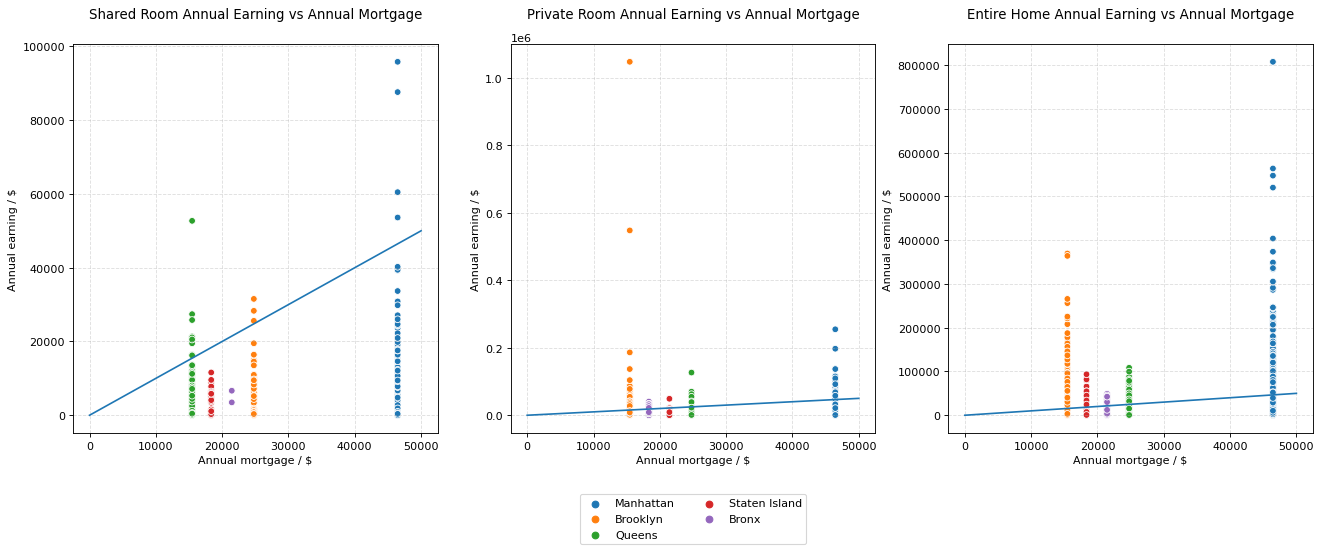

In [71]:
#PLOT ANNUAL MORTGAGE VS ANNUAL EARN


fig = plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
fig.subplots_adjust(top=0.8)

x = np.arange(50000)
y=x

### SHARED ROOM
ax1 = fig.add_subplot(131)
ax1 = sns.scatterplot(shared_room.annual_mortgage, shared_room.annual_earn, hue = shared_room.neighbourhood_group)
ax1.get_legend().remove()

plt.plot(x,y)
plt.title('Shared Room Annual Earning vs Annual Mortgage',y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual mortgage / $')
plt.grid(alpha=.4,linestyle='--')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])


### PRIVATE ROOM
ax2 = fig.add_subplot(132)
ax2 = sns.scatterplot(private_room.annual_mortgage, private_room.annual_earn, hue = private_room.neighbourhood_group)

plt.plot(x,y)

plt.title('Private Room Annual Earning vs Annual Mortgage', y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual mortgage / $')
plt.grid(alpha=.4,linestyle='--')

# Shrink current axis's height by 10% on the bottom
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

#Edit legend
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles[1:], labels=labels[1:], loc=8, 
          ncol=2, bbox_to_anchor=[0.5,-.3,0,0])


### ENTIRE HOME
ax3 = fig.add_subplot(133)
ax3 = sns.scatterplot(apt.annual_mortgage, apt.annual_earn, hue = apt.neighbourhood_group)
ax3.get_legend().remove()

plt.plot(x,y)
plt.title('Entire Home Annual Earning vs Annual Mortgage', y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual mortgage / $')
plt.grid(alpha=.4,linestyle='--')

box = ax3.get_position()
ax3.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

plt.show()

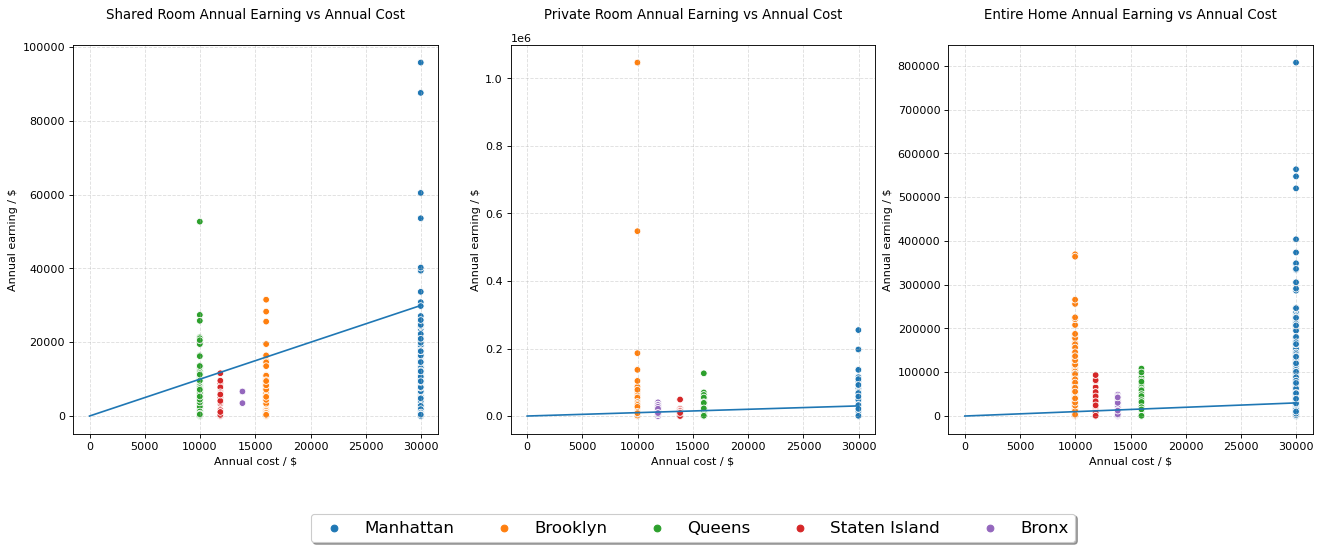

In [72]:
#PLOT ANNUAL COST VS ANNUAL EARN


fig = plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
fig.subplots_adjust(top=0.8)

x = np.arange(30000)
y=x

### SHARED ROOM
ax1 = fig.add_subplot(131)
ax1 = sns.scatterplot(shared_room.annual_cost, shared_room.annual_earn, hue = shared_room.neighbourhood_group)
ax1.get_legend().remove()

plt.plot(x,y)
plt.title('Shared Room Annual Earning vs Annual Cost', y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual cost / $')
plt.grid(alpha=.4,linestyle='--')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])


### PRIVATE ROOM
ax2 = fig.add_subplot(132)
ax2 = sns.scatterplot(private_room.annual_cost, private_room.annual_earn, hue = private_room.neighbourhood_group)

plt.plot(x,y)

plt.title('Private Room Annual Earning vs Annual Cost', y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual cost / $')
plt.grid(alpha=.4,linestyle='--')

# Shrink current axis's height by 10% on the bottom
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

#Edit legend
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles[1:], labels=labels[1:], loc=8, 
          ncol=5, bbox_to_anchor=[0.5,-.3,0,0], shadow = True, prop={"size":15})

### ENTIRE HOME
ax3 = fig.add_subplot(133)
ax3 = sns.scatterplot(apt.annual_cost, apt.annual_earn, hue = apt.neighbourhood_group)
ax3.get_legend().remove()

plt.plot(x,y)
plt.title('Entire Home Annual Earning vs Annual Cost', y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual cost / $')
plt.grid(alpha=.4,linestyle='--')

box = ax3.get_position()
ax3.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

plt.show()

<AxesSubplot:xlabel='price', ylabel='occupancy_%'>

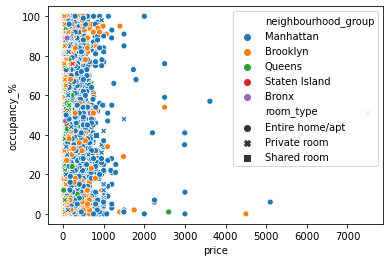

In [81]:
#PLOT ROI vs FEATURES 


fig = plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
fig.subplots_adjust(top=0.8)

x = np.arange(30000)
y=x

### SHARED ROOM
ax1 = fig.add_subplot(131)
ax1 = sns.scatterplot(shared_room.annual_cost, shared_room.annual_earn, hue = shared_room.neighbourhood_group)
ax1.get_legend().remove()

plt.plot(x,y)
plt.title('Shared Room Annual Earning vs Annual Cost', y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual cost / $')
plt.grid(alpha=.4,linestyle='--')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])


### PRIVATE ROOM
ax2 = fig.add_subplot(132)
ax2 = sns.scatterplot(private_room.annual_cost, private_room.annual_earn, hue = private_room.neighbourhood_group)

plt.plot(x,y)

plt.title('Private Room Annual Earning vs Annual Cost', y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual cost / $')
plt.grid(alpha=.4,linestyle='--')

# Shrink current axis's height by 10% on the bottom
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

#Edit legend
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles[1:], labels=labels[1:], loc=8, 
          ncol=5, bbox_to_anchor=[0.5,-.3,0,0], shadow = True, prop={"size":15})

### ENTIRE HOME
ax3 = fig.add_subplot(133)
ax3 = sns.scatterplot(apt.annual_cost, apt.annual_earn, hue = apt.neighbourhood_group)
ax3.get_legend().remove()

plt.plot(x,y)
plt.title('Entire Home Annual Earning vs Annual Cost', y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual cost / $')
plt.grid(alpha=.4,linestyle='--')

box = ax3.get_position()
ax3.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

plt.show()